In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
np.random.seed(1232)
os.chdir('C:\\Users\\rober\\Desktop\\RAND_pro\\Data\\dep')
data = pd.read_csv("Rand_train.csv", sep=',')
data_val = pd.read_csv("Rand_valid.csv", sep=',')

In [4]:
data.cost = (np.exp(data.cost) - 0.5)*((data.cost != 0) * 1)
data_val.cost = (np.exp(data_val.cost) - 0.5)*((data_val.cost != 0) * 1)
data = shuffle(data).reset_index(drop=True)
data = data.drop(['fmde', 'lxghindx', 'lpi'], axis=1)
data_val = data_val.drop(['fmde', 'lxghindx', 'lpi'], axis=1)

In [5]:
X = data.iloc[:,1:]
Y = data.iloc[:,0]
X_val = data_val.iloc[:,1:]
Y_val = data_val.iloc[:,0]

ranking = np.load('ranking.npy')

my_index = X.columns.values[ranking]
X2 = X[my_index]
X2_val = X_val[my_index]

In [6]:
cut = 0
y1 = (Y <= cut) * 1
y2 = (Y > cut) * (-1) * (-Y)
Y2 = np.stack((y1, y2), axis=-1)

y1_val = (Y_val <= cut) * 1
y2_val = (Y_val > cut) * (-1) * (-Y_val)
Y2_val = np.stack((y1_val, y2_val), axis=-1)

In [7]:
os.chdir('C:\\Users\\rober\\Desktop\\RAND_pro\\prog_calc')
from fit6_nn import fit

In [12]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        
        self.fc11 = nn.Linear(16, 24, bias = True)
        self.fc12 = nn.Linear(24, 1, bias = True)
        
        self.fc21 = nn.Linear(16, 24, bias=True)
        self.fc22 = nn.Linear(24, 5, bias=True)
        self.fc23 = nn.Linear(5, 1, bias=True)
        
        self.drop_layer = nn.Dropout(p=0.04)
                
    def forward(self, x):        
        x1 = torch.tanh(self.fc11(x))
        x1 = self.drop_layer(x1)
        x1 = torch.sigmoid(self.fc12(x1))        
        
        x2 = self.fc21(x)
        x2 = self.drop_layer(x2)
        x2 = F.relu(self.fc22(x2))
        x2 = torch.exp(self.fc23(x2))       
        
        #x3 = torch.stack((x1[:,0], x2[:,0]), dim=1) 
        x3 = torch.cat((x1, x2), 1)
        return x3

In [13]:
def comb_error(output, target):
    output = (output + 0.0001)*0.999
    logErr1 = -1 * torch.log(output) * target[:,0].view(1,-1).t()
    logErr2 = -1 * torch.log(1 - output) * (1 - target[:,0].view(1,-1)).t()
    mseErr = torch.pow(target - output, 2) * (1 - target[:,0].view(1,-1)).t()
    return (1/output.shape[0]) * (torch.sum(logErr1,dim=0)[0] + torch.sum(logErr2,dim=0)[0] + (1/(2*950000))*torch.sum(mseErr,dim=0)[1])

In [14]:
n_epochs = 5000
lr = 0.001
verbose = 1
n_batches = 6
batch_to_avg = 2
ep_to_check = 10
clipping = 0.20
PATH = 'C:\\Users\\rober\\Desktop\\RAND_pro\\Data\\checkpoints\\mytraining7.pt'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
net = Net1()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

PATH = 'C:\\Users\\rober\\Desktop\\RAND_pro\\Data\\checkpoints\\mytraining7.pt'
net.load_state_dict(torch.load(PATH, map_location = device))
    
a, b, c = fit(X=X2, X_val=X2_val, Y=Y2, Y_val=Y2_val, net=net, optimizer=optimizer, error=comb_error, 
                n_epochs=n_epochs, n_batches=n_batches, batch_to_avg=batch_to_avg, 
                    ep_to_check=ep_to_check, clipping=clipping, PATH=PATH, device=device, 
                                            verbose=verbose, min_val_loss = float('inf'))

Epoch 1: Training Loss: 0.8452078700065613, Validation Loss: 0.9552661776542664
Epoch 2: Training Loss: 0.8446500301361084, Validation Loss: 0.9552471041679382
Epoch 3: Training Loss: 0.8468146721522013, Validation Loss: 0.9553221464157104
Epoch 4: Training Loss: 0.8461055159568787, Validation Loss: 0.9553232789039612
Epoch 5: Training Loss: 0.8462536633014679, Validation Loss: 0.9553508758544922
Epoch 6: Training Loss: 0.845066100358963, Validation Loss: 0.9553971290588379
Epoch 7: Training Loss: 0.8456437687079111, Validation Loss: 0.9553653597831726
Epoch 8: Training Loss: 0.8452294170856476, Validation Loss: 0.9554581642150879
Epoch 9: Training Loss: 0.845583975315094, Validation Loss: 0.9555151462554932
Epoch 10: Training Loss: 0.8448735872904459, Validation Loss: 0.9555155038833618
Epoch 11: Training Loss: 0.8455618719259897, Validation Loss: 0.9554805755615234
New Checkpoint Saved into PATH
Epoch 12: Training Loss: 0.8452117741107941, Validation Loss: 0.9554684162139893
Epoch 13

Epoch 102: Training Loss: 0.8447116812070211, Validation Loss: 0.955495297908783
Epoch 103: Training Loss: 0.8447232147057852, Validation Loss: 0.9555590152740479
Epoch 104: Training Loss: 0.8458192547162374, Validation Loss: 0.955524206161499
Epoch 105: Training Loss: 0.8461291790008545, Validation Loss: 0.9555178880691528
Epoch 106: Training Loss: 0.8464363217353821, Validation Loss: 0.9553940892219543
Epoch 107: Training Loss: 0.845241924126943, Validation Loss: 0.9553403258323669
Epoch 108: Training Loss: 0.8460642794768015, Validation Loss: 0.9553242921829224
Epoch 109: Training Loss: 0.8456357022126516, Validation Loss: 0.9553131461143494
Epoch 110: Training Loss: 0.8474503457546234, Validation Loss: 0.9553225040435791
Epoch 111: Training Loss: 0.8460736870765686, Validation Loss: 0.9553380608558655
Epoch 112: Training Loss: 0.8461915949980418, Validation Loss: 0.9553605318069458
Epoch 113: Training Loss: 0.8450038731098175, Validation Loss: 0.9553802013397217
Epoch 114: Training

Epoch 202: Training Loss: 0.8459847271442413, Validation Loss: 0.9553014039993286
Epoch 203: Training Loss: 0.8468843499819437, Validation Loss: 0.9552540183067322
Epoch 204: Training Loss: 0.8452770709991455, Validation Loss: 0.9552608132362366
Epoch 205: Training Loss: 0.8460301458835602, Validation Loss: 0.9552707672119141
Epoch 206: Training Loss: 0.8459201355775198, Validation Loss: 0.9552573561668396
Epoch 207: Training Loss: 0.8438349664211273, Validation Loss: 0.9552513957023621
Epoch 208: Training Loss: 0.843964010477066, Validation Loss: 0.9552667737007141
Epoch 209: Training Loss: 0.8448106149832407, Validation Loss: 0.9552534222602844
Epoch 210: Training Loss: 0.8453728953997294, Validation Loss: 0.95524001121521
Epoch 211: Training Loss: 0.8461679220199585, Validation Loss: 0.9552534818649292
New Checkpoint Saved into PATH
Epoch 212: Training Loss: 0.8456620673338572, Validation Loss: 0.9552712440490723
Epoch 213: Training Loss: 0.8456221719582876, Validation Loss: 0.95529

Epoch 301: Training Loss: 0.845019668340683, Validation Loss: 0.9551826119422913
Epoch 302: Training Loss: 0.844812790552775, Validation Loss: 0.9551779627799988
Epoch 303: Training Loss: 0.8458113571008047, Validation Loss: 0.9551970958709717
Epoch 304: Training Loss: 0.8454859852790833, Validation Loss: 0.955172061920166
Epoch 305: Training Loss: 0.8456692397594452, Validation Loss: 0.95522540807724
Epoch 306: Training Loss: 0.8462648093700409, Validation Loss: 0.9552255272865295
Epoch 307: Training Loss: 0.8447457849979401, Validation Loss: 0.9552406668663025
Epoch 308: Training Loss: 0.8449180622895559, Validation Loss: 0.9552461504936218
Epoch 309: Training Loss: 0.8461754818757375, Validation Loss: 0.9552599787712097
Epoch 310: Training Loss: 0.8455185095469157, Validation Loss: 0.9552834033966064
Epoch 311: Training Loss: 0.8457127412160238, Validation Loss: 0.9552720785140991
Epoch 312: Training Loss: 0.844676285982132, Validation Loss: 0.9552179574966431
Epoch 313: Training Lo

Epoch 401: Training Loss: 0.8445650537808737, Validation Loss: 0.9551811814308167
Epoch 402: Training Loss: 0.8455400466918945, Validation Loss: 0.9551671743392944
Epoch 403: Training Loss: 0.846727579832077, Validation Loss: 0.9551032781600952
Epoch 404: Training Loss: 0.8461588422457377, Validation Loss: 0.9550700187683105
Epoch 405: Training Loss: 0.8450174033641815, Validation Loss: 0.9550288915634155
Epoch 406: Training Loss: 0.8446817795435587, Validation Loss: 0.9550461173057556
Epoch 407: Training Loss: 0.8458922604719797, Validation Loss: 0.9550946950912476
Epoch 408: Training Loss: 0.8459923068682352, Validation Loss: 0.9551401138305664
Epoch 409: Training Loss: 0.845628579457601, Validation Loss: 0.9552143216133118
Epoch 410: Training Loss: 0.8454442421595255, Validation Loss: 0.9552774429321289
Epoch 411: Training Loss: 0.8460844854513804, Validation Loss: 0.9552355408668518
New Checkpoint Saved into PATH
Epoch 412: Training Loss: 0.8459637959798177, Validation Loss: 0.9552

Epoch 500: Training Loss: 0.8460726737976074, Validation Loss: 0.9549176692962646
Epoch 501: Training Loss: 0.8442586461702982, Validation Loss: 0.9549711346626282
New Checkpoint Saved into PATH
Epoch 502: Training Loss: 0.8457003831863403, Validation Loss: 0.9549551010131836
Epoch 503: Training Loss: 0.8451519012451172, Validation Loss: 0.9550058841705322
Epoch 504: Training Loss: 0.8452020287513733, Validation Loss: 0.9550430774688721
Epoch 505: Training Loss: 0.8455635110537211, Validation Loss: 0.9549924731254578
Epoch 506: Training Loss: 0.8457314074039459, Validation Loss: 0.9550371170043945
Epoch 507: Training Loss: 0.8439004321893057, Validation Loss: 0.9550347328186035
Epoch 508: Training Loss: 0.845012754201889, Validation Loss: 0.9550550580024719
Epoch 509: Training Loss: 0.8436608215173086, Validation Loss: 0.9549779295921326
Epoch 510: Training Loss: 0.8453073700269064, Validation Loss: 0.9549319744110107
Epoch 511: Training Loss: 0.8456277946631113, Validation Loss: 0.955

Epoch 599: Training Loss: 0.8446398774782816, Validation Loss: 0.9548551440238953
Epoch 600: Training Loss: 0.8455170094966888, Validation Loss: 0.9549306631088257
Epoch 601: Training Loss: 0.8456919193267822, Validation Loss: 0.9550154209136963
New Checkpoint Saved into PATH
Epoch 602: Training Loss: 0.8455175360043844, Validation Loss: 0.9550475478172302
Epoch 603: Training Loss: 0.8455958863099416, Validation Loss: 0.9550511240959167
Epoch 604: Training Loss: 0.8446247378985087, Validation Loss: 0.9550544023513794
Epoch 605: Training Loss: 0.8448832035064697, Validation Loss: 0.9550985097885132
Epoch 606: Training Loss: 0.8445301651954651, Validation Loss: 0.9551964402198792
Epoch 607: Training Loss: 0.8455913364887238, Validation Loss: 0.9551766514778137
Epoch 608: Training Loss: 0.8460234602292379, Validation Loss: 0.9551095366477966
Epoch 609: Training Loss: 0.8442065715789795, Validation Loss: 0.9551104307174683
Epoch 610: Training Loss: 0.8447386225064596, Validation Loss: 0.95

Epoch 699: Training Loss: 0.8445462584495544, Validation Loss: 0.9549918174743652
Epoch 700: Training Loss: 0.8465067744255066, Validation Loss: 0.9550008773803711
Epoch 701: Training Loss: 0.8440929253896078, Validation Loss: 0.9549691081047058
Epoch 702: Training Loss: 0.8439174294471741, Validation Loss: 0.9549560546875
Epoch 703: Training Loss: 0.8453179697195689, Validation Loss: 0.954925000667572
Epoch 704: Training Loss: 0.8442886769771576, Validation Loss: 0.9548673629760742
Epoch 705: Training Loss: 0.845667709906896, Validation Loss: 0.9548683166503906
Epoch 706: Training Loss: 0.8454364438851675, Validation Loss: 0.9548248052597046
Epoch 707: Training Loss: 0.8457406957944235, Validation Loss: 0.9548463225364685
Epoch 708: Training Loss: 0.8449476460615793, Validation Loss: 0.9548137187957764
Epoch 709: Training Loss: 0.8448418180147806, Validation Loss: 0.9548717737197876
Epoch 710: Training Loss: 0.8440034687519073, Validation Loss: 0.954939603805542
Epoch 711: Training Lo

Epoch 800: Training Loss: 0.8452627460161845, Validation Loss: 0.954930305480957
Epoch 801: Training Loss: 0.84485990802447, Validation Loss: 0.9549201130867004
New Checkpoint Saved into PATH
Epoch 802: Training Loss: 0.8445352216561636, Validation Loss: 0.9549587965011597
Epoch 803: Training Loss: 0.846005916595459, Validation Loss: 0.9549877643585205
Epoch 804: Training Loss: 0.8440479338169098, Validation Loss: 0.9550066590309143
Epoch 805: Training Loss: 0.8458457986513773, Validation Loss: 0.9549748301506042
Epoch 806: Training Loss: 0.843769778807958, Validation Loss: 0.9550085663795471
Epoch 807: Training Loss: 0.8441137174765269, Validation Loss: 0.9550251364707947
Epoch 808: Training Loss: 0.8440393408139547, Validation Loss: 0.9550226926803589
Epoch 809: Training Loss: 0.8439837793509165, Validation Loss: 0.954960823059082
Epoch 810: Training Loss: 0.8444086611270905, Validation Loss: 0.9548923969268799
Epoch 811: Training Loss: 0.8445733884970347, Validation Loss: 0.95474475

In [30]:
PATH = 'C:\\Users\\rober\\Desktop\\RAND_pro\\Data\\checkpoints\\mytraining7.pt'
initial = X2.shape[1]
final = int(round(initial * 1.5, 0)) 
device = torch.device('cpu')
net = Net1()
net.load_state_dict(torch.load(PATH, map_location = device))

In [31]:
with torch.no_grad():
    val_inputs = torch.FloatTensor(X2_val.values)
    val_labels = torch.FloatTensor(Y2_val)
    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
    val_outputs = net.forward(val_inputs)
    val_loss = comb_error(val_outputs, val_labels) 
    print(val_loss.item())

0.8520216345787048


In [32]:
val_outputs

tensor([[4.4681e-01, 6.8842e+01],
        [3.6409e-01, 1.4205e+02],
        [5.9670e-01, 6.6173e+01],
        ...,
        [3.2402e-01, 1.8122e+02],
        [3.6846e-02, 8.3972e+02],
        [7.1055e-01, 5.9748e+00]])

In [33]:
val_labels

tensor([[  1.0000,  -0.0000],
        [  1.0000,  -0.0000],
        [  1.0000,  -0.0000],
        ...,
        [  0.0000,  10.5326],
        [  0.0000, 113.7847],
        [  1.0000,  -0.0000]])

In [34]:
val_outputs = val_outputs.numpy()
val_labels = val_labels.numpy()
y_scores = val_outputs[:,0]
y_real = val_labels[:,0]

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [36]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

0.7988319923803795


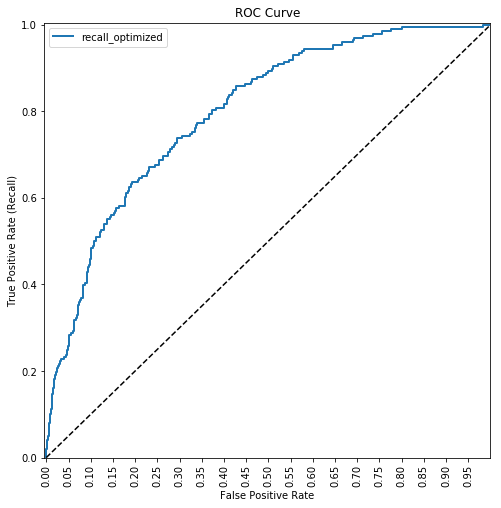

In [37]:
fpr, tpr, auc_thresholds = roc_curve(y_real, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [38]:
y = val_labels[:,1][val_labels[:,1]>0]
yhat = val_outputs[:,1][val_labels[:,1]>0]

In [39]:
RMSE = np.sqrt(np.mean((y - yhat)**2))
RMSE

1032.9951

In [40]:
y = np.abs(val_labels[:,1])
p = val_outputs[:,0]
f2 = val_outputs[:,1]
yhat = (1-p)*f2

In [41]:
RMSE = np.sqrt(np.mean((y - yhat)**2))
RMSE

928.63586

In [42]:
print(np.cov(y, p))

[[ 9.70960988e+05 -3.21676627e+01]
 [-3.21676627e+01  3.05584785e-02]]


In [43]:
print(np.cov(f2, p))

[[ 8.73141042e+04 -2.80855152e+01]
 [-2.80855152e+01  3.05584785e-02]]
